In [1]:
%matplotlib inline

# Sample reuse strategy implementation for 2+ marginals

https://hackmd.io/@cweniger/S1FJ1wafD

This is a simulation of the reuse strategy. The goal is to determine if we get the correct p(z). The simulatior is ignored for now.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import truncnorm, uniform

from typing import Callable, Union

float_type = Union[float, np.float64]

In [3]:
def get_pdf_max(pdf: Callable[[int], np.ndarray], a: float_type, b: float_type) -> float_type:
    x = np.linspace(a, b, 100)
    return pdf(x).max(axis=0)

# def draw_w_each_dim_drawn(maximum: np.ndarray) -> np.ndarray:
#     try:
#         num_marginals = len(maximum)
#     except TypeError:
#         num_marginals = 1
#     return np.random.rand(num_marginals) * maximum

# def draw_w_same_rand_mul_by_max(maximum: np.ndarray) -> np.ndarray:
#     try:
#         num_marginals = len(maximum)
#     except TypeError:
#         num_marginals = 1
#     return np.random.rand() * maximum

def draw_w(maximum: np.ndarray) -> np.ndarray:
    try:
        num_marginals = len(maximum)
    except TypeError:
        num_marginals = 1
    return np.ones(num_marginals) * np.random.rand() * np.max(maximum)

class CombinedDist(object):
    def __init__(self, dists: list):
        self.dists = dists
    
    def rvs(self, n=None):
        return np.stack([d.rvs(n) for d in self.dists], axis=-1)
    
    def pdf(self, x):
#         return np.stack([d.pdf(xx) for xx, d in (x, self.dists)], axis=-1)
        return np.stack([d.pdf(x) for d in self.dists], axis=-1)
    
    def logpdf(self, x):
#         return np.stack([d.logpdf(xx) for xx, d in (x, self.dists)], axis=-1)
        return np.stack([d.logpdf(x) for d in self.dists], axis=-1)

def accept_reject(zp, zp_existing, existing_pdf, existing_pdf_maximum):
    """zp ~ P(z), zp_existing ~ P'(z), existing_data_pdf = P', existing_data_pdf_maximum = max P' (marginal-wise)"""
    try:
        assert len(zp) == len(zp_existing)
        num_marginals = len(zp)
    except TypeError:
        num_marginals = 1
    
    w = draw_w(existing_pdf_maximum)
    existing_pdf_on_zp = existing_pdf(zp)
    if existing_pdf_on_zp.ndim == 1:
        pass
    elif existing_pdf_on_zp.ndim == 2:
        existing_pdf_on_zp = np.diagonal(existing_pdf_on_zp)
    else:
        TypeError()
        
    if np.all(existing_pdf_on_zp >= w):
        accept = True
        return zp_existing, accept
    else:
        accept = False
        return zp, accept

In [4]:
def swyft_accept_reject_loop(num_samples, existing_dist, target_dist, existing_pdf_maximum):
    accepts = 0
    zs = []
    for _ in range(num_samples):
        zp = target_dist.rvs()
        zp_existing = existing_dist.rvs()
        z, accept = accept_reject(zp, zp_existing, target_dist.pdf, existing_pdf_maximum)
        accepts += accept
        zs.append(z)
    return np.asarray(zs), accepts

def plot(p, existing_p, zs):
    fig, ax = plt.subplots()

    x = np.linspace(a, b, 100)
    ax.plot(x, p.pdf(x), label='p')
    ax.plot(x, existing_p.pdf(x), label="p'")
    ax.hist(zs, density=True, alpha=0.2)
    ax.legend()
    
    fig.show()

def plot_multi(p, existing_p, zs):
    n_marginals = zs.shape[-1]
    fig, axes = plt.subplots(n_marginals)
    
    for i, ax in enumerate(axes):
        x = np.linspace(a, b, 100)
        ax.plot(x, p.pdf(x)[:, i], label='p')
        ax.plot(x, existing_p.pdf(x)[:, i], label="p'")
        ax.hist(zs[:, i], density=True, alpha=0.2)
        ax.legend()
    
    fig.show()

#### P'(z) = arbitrary, P(z) = uniform
Let our cache distribution P'(z) = truncnorm(-1,1) and target (prior) distribution P(z) = U(-1,1).

1-dim first

In [5]:
a = -1
b = 1

# for truncnorm
locs = [-0.5, 0.5]
scales = [0.4, 1.6]

p = uniform(loc=a, scale=b-a)
loc = locs[0]
scale = scales[0]
existing_p = truncnorm((a-loc) / scale, (b-loc) / scale, loc, scale)

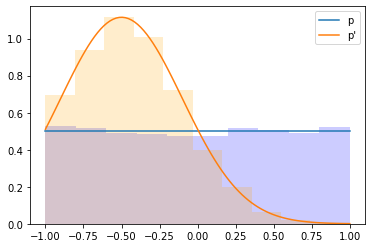

In [6]:
# Samples from each distribution

fig, ax = plt.subplots()

x = np.linspace(a, b, 100)

ax.plot(x, p.pdf(x), label='p')
ax.plot(x, existing_p.pdf(x), label="p'")
ax.hist(p.rvs(10000), density=True, alpha=0.2, color='blue')
ax.hist(existing_p.rvs(10000), density=True, alpha=0.2, color='orange')
ax.legend()

fig.show()

1.1151948943902705
total: 10000, accepted: 7662


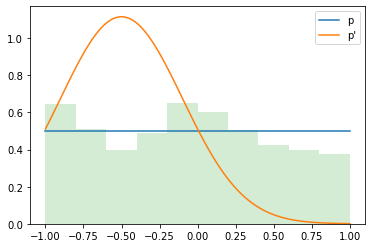

In [7]:
existing_pdf_maximum = get_pdf_max(existing_p.pdf, a, b)
print(existing_pdf_maximum)

total = 10000
zs, accepted = swyft_accept_reject_loop(total, p, existing_p, existing_pdf_maximum)
print(f"total: {total}, accepted: {accepted}")

plot(p, existing_p, zs)

2-dim

In [8]:
p = CombinedDist([uniform(loc=a, scale=b-a), uniform(loc=a, scale=b-a)])
existing_p = CombinedDist([
    truncnorm((a-loc) / scale, (b-loc) / scale, loc, scale) for loc, scale in zip(locs, scales)
])

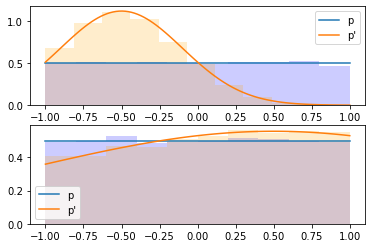

In [9]:
# Samples from each distribution

fig, axes = plt.subplots(2)

x = np.linspace(a, b, 100)
for i, ax in enumerate(axes):
    ax.plot(x, p.pdf(x)[:, i], label='p')
    ax.plot(x, existing_p.pdf(x)[:, i], label="p'")
    ax.hist(p.rvs(10000)[:, i], density=True, alpha=0.2, color='blue')
    ax.hist(existing_p.rvs(10000)[:, i], density=True, alpha=0.2, color='orange')
    ax.legend()

fig.show()

total: 50000, accepted: 21614


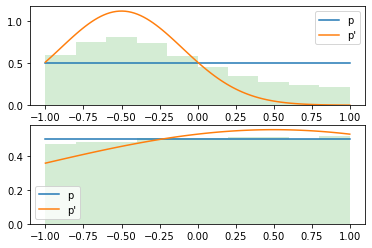

In [10]:
existing_pdf_maximum = get_pdf_max(existing_p.pdf, a, b)

total = 50000
zs, accepted = swyft_accept_reject_loop(total, p, existing_p, existing_pdf_maximum)
print(f"total: {total}, accepted: {accepted}")

plot_multi(p, existing_p, zs)